In [101]:
%reload_ext autoreload
%autoreload 2

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

from blob import *
import time
import pickle

import matplotlib.animation as animation

# Generate Distance Grids

In [70]:
im = cv2.imread("../data/maps/map_complex_1cm.png")
# im = cv2.imread("../data/maps/map_circle_1cm.png")
frame = imutils.resize(im, height=300, inter=cv2.INTER_AREA)

display(frame)
im.shape, frame.shape

((500, 700, 3), (300, 420, 3))

In [71]:
Wall = Blob(([200], [255]), frame, dilate_iter=0, heightMin=5)
Wall.checkContours()

In [72]:
blank = np.zeros(frame.shape[:2]).astype(np.uint8)
walls = blank.copy()
for cnt in Wall.cnts:
    cv2.fillPoly(walls, pts=[cnt], color=255)
display(walls)

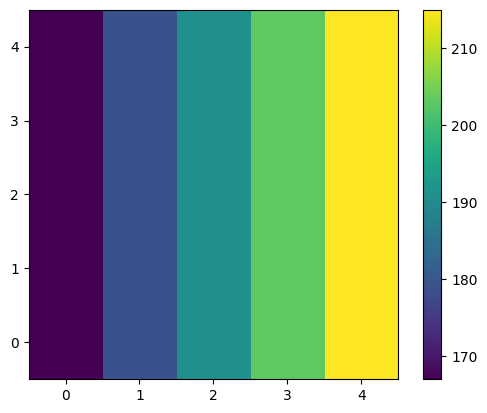

In [73]:
P = (5,5)
N = (7,5)

PF = ParticleFilter(frame, Wall.cnts, P=P, N=N)
PF.pixelDistDebug = True
xCoords, yCoords, dists = PF.getDistGrid((6, 4), 90)
distGrid = np.array(dists).reshape((P))
plt.imshow(distGrid.T, origin="lower")
plt.colorbar()


(70, 50)

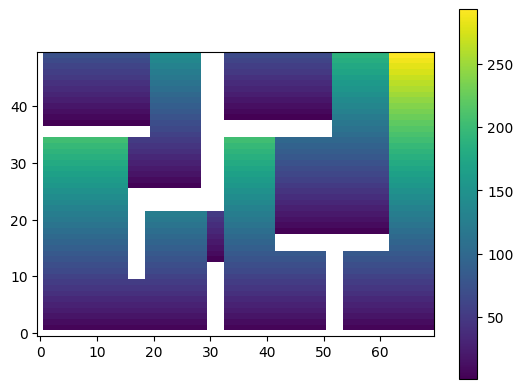

In [74]:
P = (10,10)
N = (7,5)
PF = ParticleFilter(frame, Wall.cnts, P=P, N=N)

dists = PF.plotDistMap(180)

plt.imshow(dists.T, origin="lower", interpolation=None)
plt.colorbar()
dists.shape

In [75]:
distsAll = []
start = time.time()
for deg in range(0, 360):
    dists = PF.plotDistMap(deg)
    distsAll.append(dists)
    print(f"Deg: {deg}, Time: {time.time()-start}")

Deg: 0, Time: 0.23057913780212402
Deg: 1, Time: 0.46711015701293945
Deg: 2, Time: 0.730339765548706
Deg: 3, Time: 0.9696075916290283
Deg: 4, Time: 1.2163403034210205
Deg: 5, Time: 1.4602084159851074
Deg: 6, Time: 1.702134609222412
Deg: 7, Time: 1.9413764476776123
Deg: 8, Time: 2.1614999771118164
Deg: 9, Time: 2.391636848449707
Deg: 10, Time: 2.6250617504119873
Deg: 11, Time: 2.854938507080078
Deg: 12, Time: 3.1003780364990234
Deg: 13, Time: 3.3620827198028564
Deg: 14, Time: 3.6037099361419678
Deg: 15, Time: 3.8346362113952637
Deg: 16, Time: 4.030959606170654
Deg: 17, Time: 4.2075018882751465
Deg: 18, Time: 4.38440203666687
Deg: 19, Time: 4.569146633148193
Deg: 20, Time: 4.736785888671875
Deg: 21, Time: 4.956241846084595
Deg: 22, Time: 5.194895029067993
Deg: 23, Time: 5.430694580078125
Deg: 24, Time: 5.669108867645264
Deg: 25, Time: 5.900363206863403
Deg: 26, Time: 6.10409951210022
Deg: 27, Time: 6.275949001312256
Deg: 28, Time: 6.464728355407715
Deg: 29, Time: 6.645028352737427
Deg: 30

nan

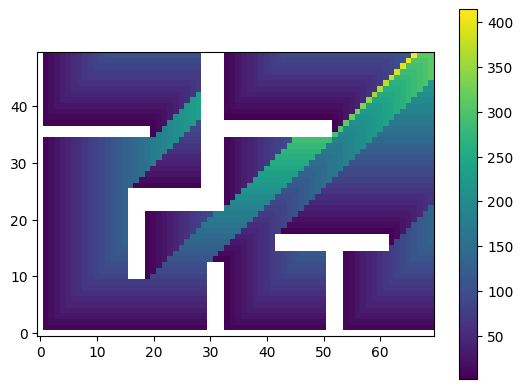

In [77]:
plt.imshow(distsAll[135].T, origin="lower", interpolation=None)
plt.colorbar()

In [79]:
# pickle.dump( distsAll, open( "map_complex_1cm.p", "wb" ) )

# Particle Filter

In [123]:
distsGrids = pickle.load(open("map_complex_1cm.p", "rb"))
wallsIm = distsGrids[100].copy()
wallsIm[np.logical_not(np.isnan(wallsIm))] = 100
wallsIm[np.isnan(wallsIm)] = 10
distsGrids = convertToInt(distsGrids)

def resample(weights):
    n = len(weights)
    indices = []
    C = [0.] + [sum(weights[:i + 1]) for i in range(n)]
    (u0, j) = (np.random.random(), 0)
    for u in [(u0 + i) / n for i in range(n)]:
        while u > C[j]:
            j += 1
        indices.append(j - 1)
    return indices

def particlefilterTest(start, end, nP, steps, randomVar):
    stepSize = ((end-start)/(steps, steps)).astype(int)
    pos = start.copy().astype(int)

    PPos = []
    Px = np.round(np.random.uniform(0, distsGrids.shape[1]-1, nP)).astype(int)
    Py = np.round(np.random.uniform(0, distsGrids.shape[2]-1, nP)).astype(int)
    weights = np.zeros(nP)
    PPos.append([Px, Py])

    for i in range(steps):
        expectedFront = distsGrids[315][pos[0]][pos[1]]
        expectedLeft = distsGrids[0][pos[0]][pos[1]]
        expectedRight = distsGrids[270][pos[0]][pos[1]]

        for j in range(nP):
            frontErr = expectedFront - distsGrids[315][Px[j]][Py[j]]
            leftErr = expectedLeft - distsGrids[0][Px[j]][Py[j]]
            rightErr = expectedRight - distsGrids[270][Px[j]][Py[j]]

            # err = frontErr**2 + leftErr**2 + rightErr**2
            # err = frontErr**2
            err = frontErr**2 + leftErr**2
            weights[j] = 1/max(err,1)

        weights /= sum(weights)  # Normalize w
        expectedXPos, expectedYPos = sum(Px*weights), sum(Py*weights)  # Return expected position
        if 1. / sum(weights ** 2) < nP / 2.:  # If particle cloud degenerate:
            # print('resampled')/
            Px = Px[resample(weights)]  # Resample particles according to weights
            Py = Py[resample(weights)]

        PPos.append([Px, Py])
        Px = Px.copy()
        Py = Py.copy()

        # Particle motion model: uniform step
        np.add(Px, np.random.uniform(-randomVar, randomVar, Px.shape), out=Px, casting="unsafe")
        np.add(Py, np.random.uniform(-randomVar, randomVar, Py.shape), out=Py, casting="unsafe")    

        # Clip out-of-bounds particles
        Px = np.clip(Px, 0, distsGrids.shape[1]-1).astype(int)  
        Py = np.clip(Py, 0, distsGrids.shape[2]-1).astype(int)

        pos += stepSize
    return PPos, stepSize


In [124]:
# start = np.array([80, 50]).astype(np.float64)
# end = np.array([40, 10]).astype(np.float64)

start = np.array([10, 10]).astype(np.float64)
end = np.array([60, 40]).astype(np.float64)
nFrames = 20

PPos, stepSize = particlefilterTest(start, end, 1000, nFrames, 4)

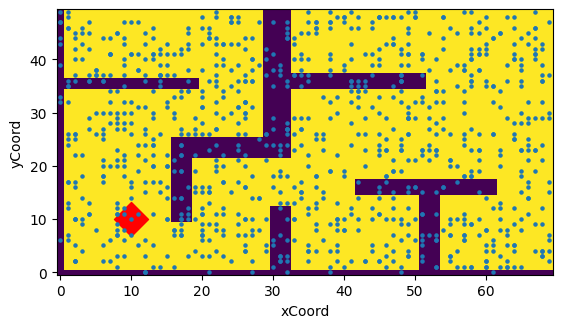

MovieWriter ffmpeg unavailable; using Pillow instead.


In [125]:
x = start.copy()
fig, ax = plt.subplots()
fig.subplots_adjust()

scat1 = ax.scatter(x[0], x[1], color="red", s=300, marker="D")
scat2 = ax.scatter(PPos[0][0], PPos[0][1], s=5)
ax.imshow(wallsIm.T, origin="lower", interpolation=None)
ax.set_aspect(aspect=270/360)
ax.set_xlabel("xCoord")
ax.set_ylabel("yCoord")

def animate(i):
    global x
    scat1.set_offsets(np.transpose([x[0], x[1]]))
    scat2.set_offsets(np.transpose([PPos[i][0], PPos[i][1]]))
    x = start+stepSize*i

anim = animation.FuncAnimation(
    fig, animate, interval=100, frames=nFrames)
 
plt.draw()
plt.show()
anim.save("Particle Filter.gif", dpi=200)